<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">SWDB 2023 - Day 5 Workshop 1: What gives rise to neural variability and dynamics?</h1> 
<h3 align="center">Friday, August 25th, 2023</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> What could models of neural variability and dynamics tell us about the brain? </h2>
<ul>
<li> How does stimulus influence neuronal responses and variability? 
<li> How does stimulus interact with time course of the trial?
<li> How does neural activity depend on its past response?
<li> How do population of neurons interact over time to shape neural dynamics?
</ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Imports </h2>
    
</div>

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # Useful tool to arrange multiple plots in one figure (https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html)
%matplotlib inline

import platform

import allensdk
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2> Load Data </h2>
    <p> We will be working with the Allen institute's Visual Coding Neuropixel dataset from earlier in the week <p>
</div>

In [2]:
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

In [21]:
# Code Ocean
data_path = Path(data_root) / 'allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json'
cache = EcephysProjectCache.from_warehouse(manifest=data_path)

print(cache.get_all_session_types())

['brain_observatory_1.1', 'functional_connectivity']


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <p> The dataset consists of two subsets. We'll specifically be looking at the Brain Observatory subset </p>
</div>

In [22]:
sessions = cache.get_session_table()
brain_observatory_type_sessions = sessions[sessions["session_type"] == "brain_observatory_1.1"]
brain_observatory_type_sessions.tail()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
773418906,2019-10-03T00:00:00Z,757329624,brain_observatory_1.1,124.0,F,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,546,2232,6,"[PPT, NOT, SUB, ProS, CA1, VISam, nan, APN, DG..."
791319847,2019-10-03T00:00:00Z,769360779,brain_observatory_1.1,116.0,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,555,2229,6,"[APN, DG, CA1, VISam, nan, LP, TH, VISpm, POL,..."
797828357,2019-10-03T00:00:00Z,776061251,brain_observatory_1.1,107.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,611,2232,6,"[PPT, MB, APN, NOT, HPF, ProS, CA1, VISam, nan..."
798911424,2019-10-03T00:00:00Z,775876828,brain_observatory_1.1,110.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,825,2233,6,"[APN, TH, Eth, LP, DG, HPF, CA3, CA1, VISrl, n..."
799864342,2019-10-03T00:00:00Z,772616823,brain_observatory_1.1,129.0,M,wt/wt,604,2233,6,"[APN, POL, LP, DG, CA1, VISrl, nan, LGd, CA3, ..."


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h3> Choose a random session to examine: 791319847 </h3>
    
</div>

In [23]:
session_id = 791319847
session = cache.get_session_data(session_id)

Note: As in Day 2, before we proceed further, we are going to patch AllenSDK to get around a known discrepancy between the NWB files contained in the AWS bucket and what is expected by the latest version of the AllenSDK.

In [24]:
from allensdk.brain_observatory.ecephys.stimulus_table import naming_utilities

def passthrough_function(input):
    return input

naming_utilities.standardize_movie_numbers = passthrough_function
session.naming_utilities = naming_utilities # this is needed to circumvent a bug in the AllenSDK

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> Let's explore the breakdown by brain region: </p>
</div>

In [25]:
# check number of neurons per region
session.structurewise_unit_counts

VISp     93
CA1      85
VISrl    58
VISl     56
VISam    49
VISal    43
SUB      41
CA3      33
DG       32
VISpm    17
LGv      16
LP        9
LGd       8
TH        4
ZI        4
CA2       3
POL       3
ProS      1
Name: ecephys_structure_acronym, dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h3> Look at the effect of stimulus on neuronal variabiity </h3>
    
<p> Here, we'll focus on drifting gratings stimulus: </p>

</div>

In [26]:
session.get_stimulus_table(["drifting_gratings"])

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,90.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1590.469172,2.0,drifting_gratings,1592.470862,15.0,2.00169,246
3799,0.8,135.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1593.471657,2.0,drifting_gratings,1595.473327,4.0,2.00167,247
3800,0.8,135.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1596.474152,2.0,drifting_gratings,1598.475832,2.0,2.00168,248
3801,0.8,0.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1599.476677,2.0,drifting_gratings,1601.478347,1.0,2.00167,249
3802,0.8,225.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1602.479182,2.0,drifting_gratings,1604.480862,1.0,2.00168,250
...,...,...,...,...,...,...,...,...,...,...,...,...
49428,0.8,90.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5388.643497,7.0,drifting_gratings,5390.645187,1.0,2.00169,259
49429,0.8,270.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5391.646002,7.0,drifting_gratings,5393.647682,4.0,2.00168,270
49430,0.8,270.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5394.648527,7.0,drifting_gratings,5396.650207,4.0,2.00168,270


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Exercise 1:</b>
    <ul>
        <li> How many distinct orientations are present?
        <li> How long are stimuli presented for?
    </ul>
</div>

There are 9 unique orientations
The unique orientations are: [90.0 135.0 0.0 225.0 315.0 270.0 'null' 180.0 45.0]


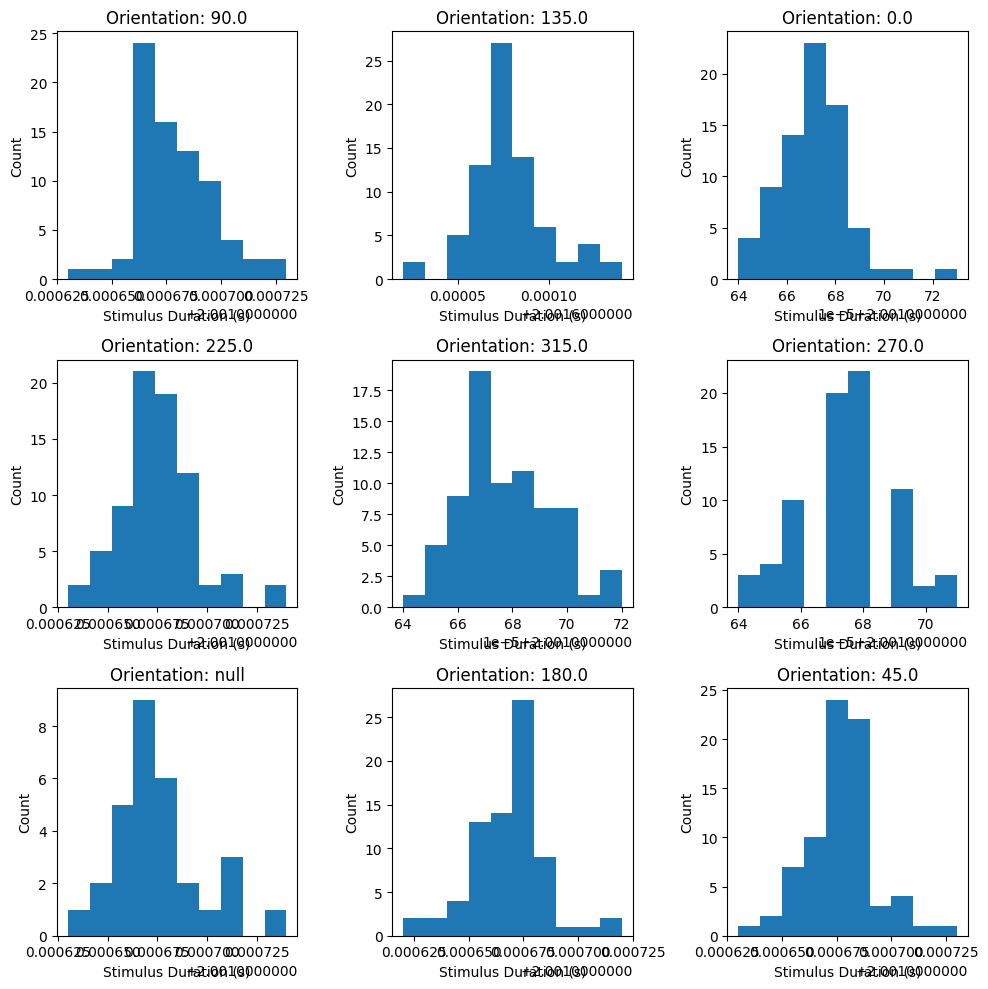

In [27]:
# Code: compute distinct orientations
# Hint: dataframe columns have a .unique() function

#find the number of unique orientations 
unique_orientations = session.get_stimulus_table(["drifting_gratings"])["orientation"].unique()

#print the number of unique orientations 
print("There are " + str(len(unique_orientations)) + " unique orientations")

#print the unique orientations 
print("The unique orientations are: " + str(unique_orientations))

# Code: how would you visualize the distribution of stimulus durations?

# in a for loop with grid spec 
fig = plt.figure(figsize = (10, 10))
gs = GridSpec(3, 3)

for i, orientation in enumerate(unique_orientations):
    stimulus_table = session.get_stimulus_table(["drifting_gratings"])
    stimulus_table = stimulus_table[stimulus_table["orientation"] == orientation]
    ax = fig.add_subplot(gs[i])
    ax.hist(stimulus_table["duration"]) 
    ax.set_title("Orientation: " + str(orientation))
    ax.set_xlabel("Stimulus Duration (s)")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2> Looking at ephys data </h2>
    <p> In order to analyze neuronal responses to the stimulus, we need to decide how we would quantify this neuronal response. Some things to consider are: 
    <ul>
        <li> What brain areas to look at?
        <li> Which time interval response to look at (e.g. what should be the alignment?)
        <li> How large should time bins be to count spikes?
        <li> When to start and stop counting for each trial?
    </ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> For the rest of the notebook, we will:
    <ul>
        <li> Only look at V1 neurons
        <li> Align spike times to the stimulus onset. 
        <li> Use a bin size of 50ms to count spikes. 
        <li> Analyze a trial interval starting 100ms before stimulus onset to 500ms after.
    </ul>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2:</b>   complete the following block of code according to the specifications above for analyzing neuronal responses
</div>

In [44]:
# Code: define region, time_step (in seconds), 
# and time_bins (a numpy array for bin edges)

# Code: define region, time_step (in seconds), 
# and time_bins (a numpy array for bin edges)
region = 'VISp'
time_step = 0.01  # in seconds
time_bins = np.arange(-0.1, 0.5 + time_step, time_step)

In [45]:
presentations = session.get_stimulus_table("drifting_gratings")
# filter out "null trials"
presentations = presentations[presentations.orientation != 'null']
# select only V1 neurons
units = session.units[session.units["ecephys_structure_acronym"] == region]

# use SDK function to count spikes into bins
spikes = session.presentationwise_spike_counts(
    stimulus_presentation_ids=presentations.index.values,  
    bin_edges=time_bins,
    unit_ids=units.index.values
)

# grab distinct orientations (directions)
unique_orientations = presentations.orientation.unique()
unique_orientations.sort()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> Let's visualize the firing rate of each VISp neuron (averaged across stim presentations), aligned on stimulus onset

</div>

/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_2049/3851626752.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(


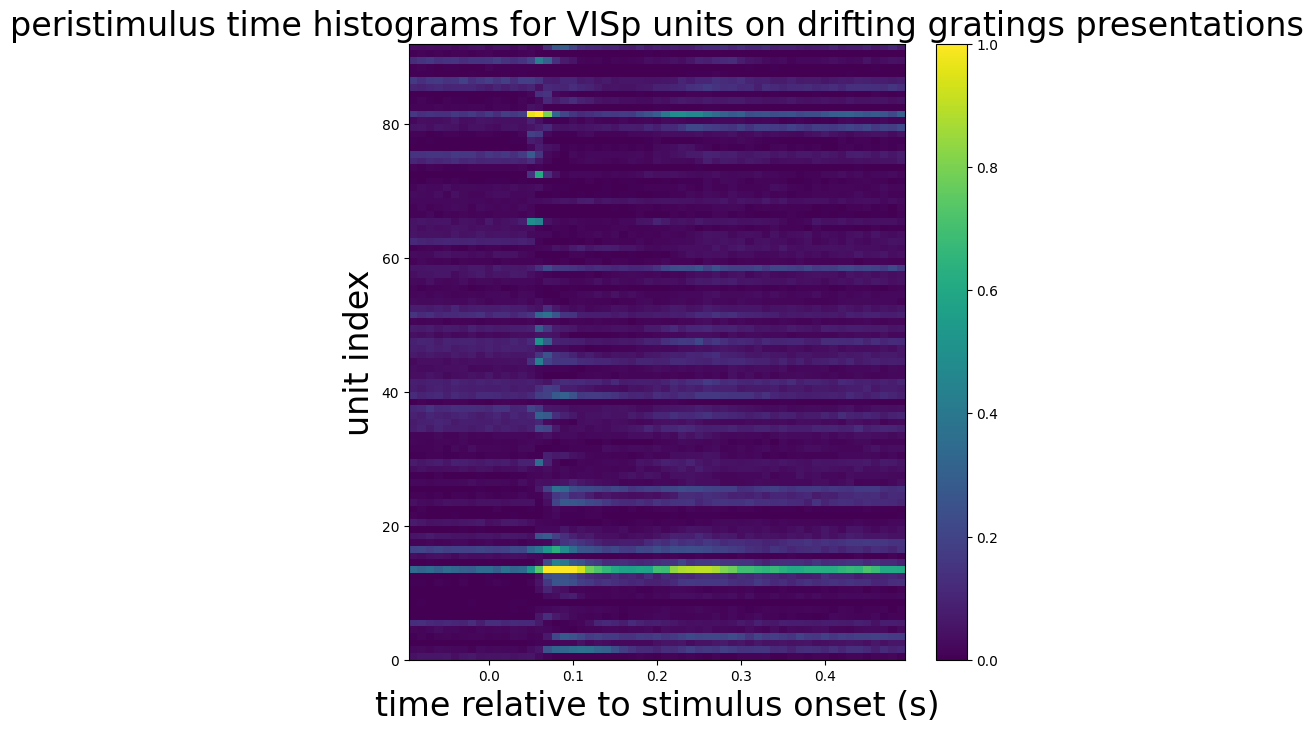

In [46]:
mean_spikes = spikes.mean(dim="stimulus_presentation_id")

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.pcolormesh(
    mean_spikes["time_relative_to_stimulus_onset"], 
    np.arange(mean_spikes["unit_id"].size),
    mean_spikes.T, 
    vmin=0,
    vmax=1
)
fig.colorbar(im, ax=ax)
ax.set_ylabel("unit index", fontsize=24)
ax.set_xlabel("time relative to stimulus onset (s)", fontsize=24)
ax.set_title("peristimulus time histograms for VISp units on drifting gratings presentations", fontsize=24)

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> How does each neuron respond specifically to different grating orientations? </h3>
    <ul> 
        <li> Namely, how much do differences in the presented orientations explain neural variability?
        <li> What's the best way to visualize this?
    </ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> One approach is to plot the spike counts of a few units as a function of time, averaged across repeats for each unique stimulus grating orientation
</div

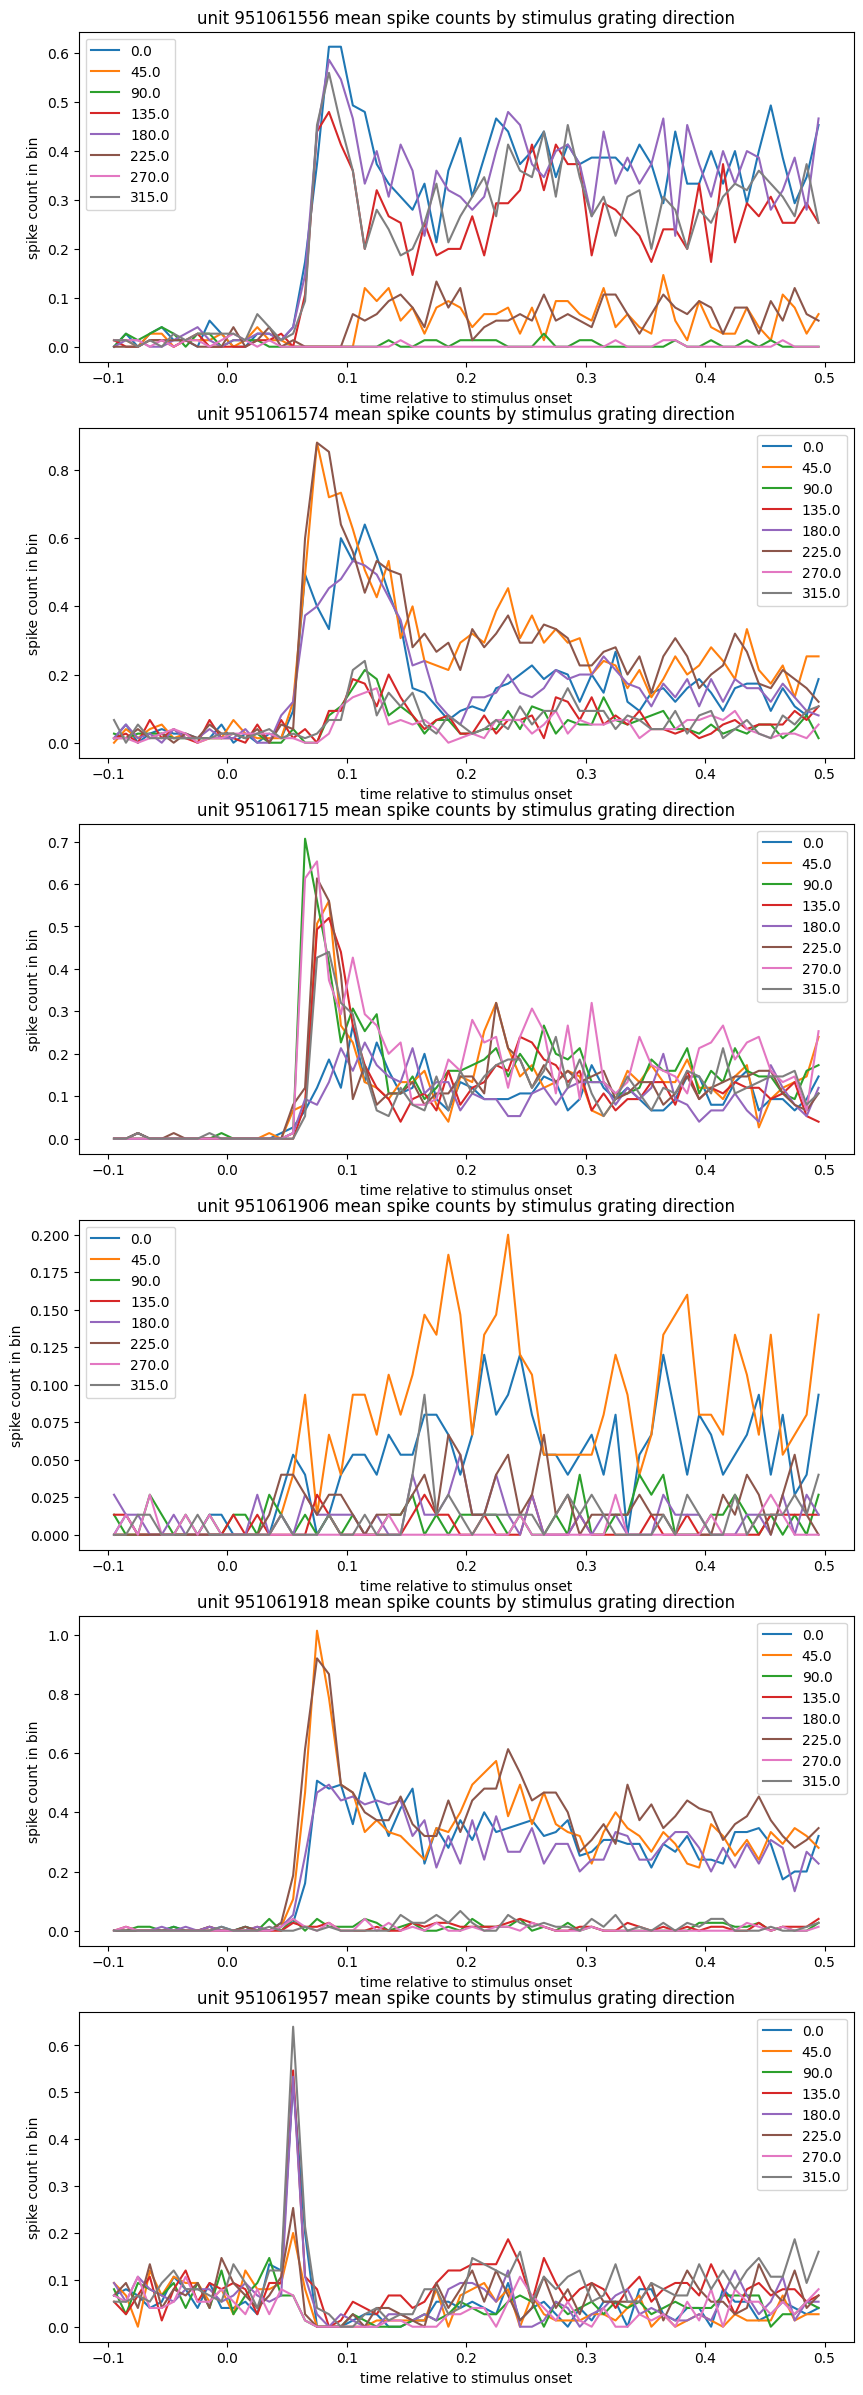

In [47]:
# for each unit, make plots of averaged responses across each orientation, aligned to stim onset

# a list of interesting units predetermined by looking data/patrick_scratch/unit_frs_analysis figures
interesting_units = [
    951061556,
    951061574,
    951061715,
    951061906,
    951061918,
    951061957
]
fig, ax = plt.subplots(len(interesting_units), 1, figsize=(10, 30))

for i, unit_id in enumerate(interesting_units):
    for orientation in unique_orientations: 
        trial_ids = presentations[presentations.orientation == orientation].index.values        
        data = spikes.loc[trial_ids, :, unit_id]
        mean = data.mean(dim="stimulus_presentation_id")
        ax[i].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
    ax[i].legend()
    ax[i].set_xlabel("time relative to stimulus onset")
    ax[i].set_ylabel("spike count in bin")
    ax[i].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Stop and think: </b>

<p> Each line is an average, in reality it varies from trial to trial. How would you visualize the variability?
    
</div>

The is trial to trial variability!!!! 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2> How can we explain variability of a single neuron? </h2>
    <ul>
        <li> Let's focus on just a single unit for a moment, here we will look at Unit 951061556. 
        <li> What is a good model for explaining neural activity with the stimulus orientation?
    </ul>
</div>

In [43]:
unit_id = 951061556

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2> Model 1: Stimulus-based regression model. </h2>
    <p> One simple first model is to learn the averaged response per orientation, and assume it does not vary with time. 
    <p> Using one-hot encoding notation for the stimulus, this can be written as a linear function:
$$ r_t = \textbf{w}^\text{stim} \cdot \textbf{s} $$
<p> Where $r_t $ is neuron's activity, $ \textbf{w}^\text{stim} $ is a vector of weights that will be fit, and $\textbf{s}$ is a one-hot encoding vector stimulus direction. 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Stop and think*: </b>

<p> Here we have chosen to represent our stimulus as one-hot vectors of 8 different directions. We could have alternatively treated the stimulus as a single continuous variable, with our model being: $ r_t = w^\text{stim} \cdot s $. What are the benefits/drawbacks of each choice?
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> How should we evaluate our model? </h3>
    <p> From the lecture, you learned the loss function for fit actually specifies "noise" distribution. Here, we will assume for simplicity a standard Gaussian for noise and use loss metric based on mean-squared error (MSE). Note, the popular $R^2$ metric is directly related to the MSE. 
    <p> Below, we define some helper functions to 
    <ul>
        <li> Calculate $R^2$
        <li> Covert stimulus into one-hot encoding
    </ul>
</div>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


def calc_r_squared(y_true, y_pred):
    """
    Calculates r^2 metric for true vs predicted labels
    NOTE: could also use .score() from sklearn LinearRegression here, but it's a bit unfitting since
    we'd want to evaluate r^2 for all time points, but are sometimes training different models for each time point. 
    Args: 
        y_true, y_pred of any shape
    """
    return 1 - np.sum((y_true - y_pred)**2) / np.sum(((y_true - y_true.mean()) ** 2))


def get_one_hot_encoding(orientations):
    """
    Generates a one-hot-encoding of stimulus directions
    Args: 
        orientations: an array of orientations as degrees, of length n_trials. Assumes that
            orientations are in 45 degree increments, with 8 unique values. 
    Returns: 
        an array of shape n_trials x 8. array has values either 0 or 1, with one 1 existing per row, 
            indicating which orientations was present for that trial. 
    """
    one_hot = np.zeros((len(orientations), 8))
    orientation_idxs = (orientations / 45).astype(int)
    one_hot[np.arange(len(orientation_idxs)), orientation_idxs] = 1
    return one_hot

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

   To avoid overfitting, we will split our dataset into train and test sets. 

</div>

In [ ]:
random_state = 42 # ensure each run has the same split
train_idxs, test_idxs = train_test_split(presentations.index.values, test_size=0.2, random_state=random_state)

orientations_train = presentations.orientation.loc[train_idxs].values
spikes_train = spikes.loc[train_idxs, :, unit_id].values

orientations_test = presentations.orientation.loc[test_idxs].values
spikes_test = spikes.loc[test_idxs, :, unit_id].values

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Here, we use sklearn to fit our model. Note that since it is a linear model, and using MSE loss, we can simply use sklearn's <code>LinearRegression</code>
</div>

In [ ]:
# prepare the data matrices for linear regression
def get_X_model_1(orientations, num_time_bins):
    """
    Generates design matrix for Model 1
    Args: 
        orientations: an array of orientations as degrees, of length n_trials. Assumes that
            orientations are in 45 degree increments, with 8 unique values. 
        num_time_bins: total number of time bins in a trial
    Returns: 
        an array of shape (n_trials x n_time_bins, 8). array has values either 0 or 1, with one 1 existing per row, 
            indicating which orientations was present for that trial. 
    """
    presentation_time_bin_start = 2
    orientations_one_hot = get_one_hot_encoding(orientations)
    X_model_1 = []
    for trial_idx in range(orientations_one_hot.shape[0]):
        for time_bin_idx in range(num_time_bins):
            # fills zeros before the stimulus presentation
            if time_bin_idx < presentation_time_bin_start:
                X_model_1.append(np.zeros(8))
            else:
                X_model_1.append(orientations_one_hot[trial_idx])
    X_model_1 = np.array(X_model_1)
    
    return X_model_1
    

num_time_bins = spikes_train.shape[1]
X_train = get_X_model_1(orientations_train, num_time_bins)
Y_train = spikes_train.flatten()
X_test = get_X_model_1(orientations_test, num_time_bins)
Y_test = spikes_test.flatten()

In [ ]:
# check one hot encoding of stimulus
print(orientations_train[0])
print(X_train[:6])

In [ ]:
# check unit's spike counts over time bins and trials
print(Y_train[:6])

In [ ]:
# now perform linear regression
reg = LinearRegression()
reg.fit(X_train, Y_train)

# caluculate train and test R^2
train_score = calc_r_squared(Y_train, reg.predict(X_train))
test_score = calc_r_squared(Y_test, reg.predict(X_test))
print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
To keep track of train/test scores as we progress in our models, let's define a dict <code>model_scores</code> to hold train test scores, with keys of that dict being the model name, and values being a tuple of train/test scores
</div>

In [ ]:
model_scores = {}
model_scores["Model 1: \n Stim-based"] = (train_score, test_score)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
And also define a helper function to help visualize and compare model scores
</div>

In [ ]:
def plot_model_scores(model_scores):
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 7))
    model_names = ["" for _ in range(6)]
    train_scores = np.zeros(6)
    test_scores = np.zeros(6)
    x = np.arange(6)  # the label locations

    for i, k in enumerate(model_scores):
        model_names[i] = k
        train_scores[i] = model_scores[k][0]
        test_scores[i] = model_scores[k][1]

    ax.bar(x, train_scores, width, label="Train")
    ax.bar(x + width, test_scores, width, label="Test")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score ($R^2$)')
    ax.set_title('Model Train/Test scores by comparison')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 0.6)
    ax.legend()

In [ ]:
plot_model_scores(model_scores)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Plot what the model predictions look like for all trials </h3>
    <p> Now that we have trained our model for this neuron's response, we can see what it's predictions look like against the stimulus-averaged true responses
</div>

In [ ]:
# plot regression result
unique_orientations.sort()

fig, ax = plt.subplots()

for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = spikes.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    line, = ax.plot(data["time_relative_to_stimulus_onset"], mean, label=int(orientation))
    predictions = reg.predict(get_X_model_1(np.array([orientation]), num_time_bins))
    ax.plot(data["time_relative_to_stimulus_onset"], predictions, color=line.get_color(), linestyle="--", label=f"{int(orientation)} predicted")

lgd_bbox_to_anchor = (1., 0.5)
lgd_loc = "center left"
ax.legend(bbox_to_anchor=lgd_bbox_to_anchor, loc=lgd_loc)
ax.set_xlabel("time relative to stimulus onset")
ax.set_ylabel("spike count in bin")
ax.set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
By design, the predicted response to each orientation can not vary with time, therefore fails to capture the unit's variation over time. How could we improve our model?
</div

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Exercise 3:</b>
    <ul>
        <li> Visualize the predicted response by orientation. In other words, plot out the orientation tuning curve of this neuron
        <li> Is the neuron orientation or direction selective?
    </ul>

</div>

In [ ]:
# Code: Visualize the predicted response against orientation
# hint: use the fitted linear regression model
# prediction = reg.predict(get_X_model_1(np.array([orientation]), num_time_bins))[2]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Observation: </h3>
    <p> unit 951061556 is an orientation-selective unit instead of a direction-selective one, and most sensitive to horizontal gratings (equally responsive to 0, 180, 360-degree gratings)
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2> Model 2: Stimulus based regression with time-varying weights </h2>
    <p> The previous model made the simpifying assumption that stimulus orientation's contribution to neuronal response is constant across the time course of a trial, hence was only able to predict constant responses over time. What if we loosened this assumption a bit, and fit a separate regression per-time-bin? Our model now becomes: 
$$ r_t = \textbf{w}^{stim}_t \cdot \textbf{s} $$
    <p> Where: 
    <ul>
        <li> $ \textbf{w}^{stim}_t $ is still a vector of learned weights, but varies by time
        </li> $ \textbf{s} $ is still one-hot encoding vector stimulus direction. This has no time component as the stimulus direction does not change within a trial. 
    </ul>
    <p> Effectively we are training separate regression models per time bin
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Stop and think:</b>
<p>What are the drawbacks of this model? What are some interesting insights this model <b>could miss</b>?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Train models </h3>
</div>

In [ ]:
# prepare the data matrices for model 2
def get_X_model_2(orientations, time_bin_idx):
    """
    Generates design matrix for Model 2
    Args: 
        orientations: an array of orientations as degrees, of length n_trials. Assumes that
            orientations are in 45 degree increments, with 8 unique values. 
        time_bin_idx: desired time bin index in a trial
    Returns: 
        an array of shape (n_trials, 8). array has values either 0 or 1, with one 1 existing per row, 
            indicating which orientations was present for that trial. 
    """
    presentation_time_bin_start = 2
    if time_bin_idx < presentation_time_bin_start:
        X_model_2 = np.zeros((orientations.shape[0], 8))
    else:
        X_model_2 = get_one_hot_encoding(orientations)
    
    return X_model_2

In [ ]:
lin_reg_results = []
Y_train_preds = []
Y_test_preds = []

# per time bin, train a separate model
for time_bin_idx in range(spikes_train.shape[1]):
    reg = LinearRegression()
    X_train = get_X_model_2(orientations_train, time_bin_idx)
    Y_train = spikes_train[:, time_bin_idx]

    X_test = get_X_model_2(orientations_test, time_bin_idx)

    reg.fit(X_train, Y_train)

    lin_reg_results.append(reg)    
    Y_train_preds.append(reg.predict(X_train))
    Y_test_preds.append(reg.predict(X_test))


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Evaluate train and test scores </h3>
</div>

In [ ]:
train_score = calc_r_squared(spikes_train, np.vstack(Y_train_preds).T)
test_score = calc_r_squared(spikes_test, np.vstack(Y_test_preds).T)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Now, we can compare our model performance against the previous Model 1 
</div>

In [ ]:
model_scores["Model 2: \n Stim with \n time varying"] = (train_score, test_score)
plot_model_scores(model_scores)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Visualize model predictions </h3>
</div>

In [ ]:
# plot regression result
fig, ax = plt.subplots()

for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = spikes.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    line, = ax.plot(data["time_relative_to_stimulus_onset"], mean, label=int(orientation))
    predictions = [reg.predict(get_X_model_2(np.array([orientation]), time_bin_idx)) 
                    for time_bin_idx, reg in enumerate(lin_reg_results)]
    ax.plot(data["time_relative_to_stimulus_onset"], predictions, color=line.get_color(), linestyle="--", label=f"{int(orientation)} predicted")
lgd_bbox_to_anchor = (1., 0.5)
lgd_loc = "center left"
ax.legend(bbox_to_anchor=lgd_bbox_to_anchor, loc=lgd_loc)
ax.set_xlabel("time relative to stimulus onset")
ax.set_ylabel("spike count in bin")
ax.set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2> What about the rest of the variability? </h2>
    <p> So far, our model has gotten fairly good at matching the stimulus-averaged responses of this neuron, though looking at the $ R^2 $ score, this still doesn't explain all of the neural variability. How variable is neuron's activity within the same stimulus condition?
    <p> To answer this question, we can plot the per-trial activity of our neuron within the same stimulus condition, plotting the mean, standard deviation, and a few example trial activities.
</div>

In [ ]:
num_example_trials_to_plot = 5
fig, axs = plt.subplots(4,2, figsize=(8,12), dpi=200)

for orientation_id, orientation in enumerate(unique_orientations):
    row = int(orientation_id% 4)
    col = int(orientation_id/ 4)
    ax = axs[row, col]
    
    trial_ids = presentations[presentations.orientation == orientation].index.values 
    data = spikes.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    mean_line, = ax.plot(data["time_relative_to_stimulus_onset"], mean, label="mean and std", lw=3)
    std = data.std(dim="stimulus_presentation_id")
    std_line = ax.fill_between(data["time_relative_to_stimulus_onset"], mean - std, mean + std, color=mean_line.get_color(), alpha=0.5)

    for i in range(num_example_trials_to_plot):
          ax.plot(data["time_relative_to_stimulus_onset"], data[i, :], label=f"example trial {i}", alpha=0.8)
    ax.set_xlabel("time relative to stimulus onset")
    ax.set_ylabel("spike count in bin")
    ax.set_title(f"{int(orientation)} degree")

plt.legend()    
fig.suptitle(f"unit {unit_id} neural variability")
fig.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <p><b>Observation: </b></p>
    <ul>
        <li> There is substantial variability within stimulus condition across trials
        <li> Within each trial, the neural response trajectory is **somewhat** smooth $\to$ there are some temporal correlations
    </ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h1> Capturing the temporal relationship in neural responses </h1>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2> Model 3: stimulus + 1 time bin back regression </h2>
    <p> One idea for trying to explain stimulus-conditioned trial-by-trial variability is to assume that a neuron's activity at a certain timepoint depends on its activity at the previous timepoint. This would mean introducing an *auto-regressive* component to our model: 
    <p> $$ r_t = \textbf{w}^\text{stim}_t \cdot \textbf{s} + w^\text{auto}_{t} r_{t-1} $$
    <p> Where:
    <ul> 
        <li> $ w^\text{auto}_t $ is the learned weight capturing how previous time bin $t - 1$ activity influences the target time bin $t$ activity. Note: here we're still learning a different weight per time bin. 
        <li> $ r_{t-1} $ is our neuron's activity at $t - 1$
    </ul>
<p> With this model, we ask: per timestep, is variation in activity explained by stim orientation as well as previous activity?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <p> First, we can define a helper function that will help generate inputs for our model, from both the stimulus orientation and the unit's past spiking data:
    <p> Note: we're defining a more generic version here, with a <code>lag</code> parameter. This will be helpful in later models, where we introduce the concept of lag. 
</div>

In [ ]:
def get_X_model_3(spikes, orientations, time_bin_idx, lag=1):
    """
    Generates a input data matrix for the lag time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps
        orientations: data array of num_trials
        time_bin_idx: index of time bin
    """
    orientations_one_hot = get_X_model_1(orientations, spikes.shape[1]).reshape(spikes.shape[0],
                                                                                spikes.shape[1],
                                                                                8)
    spikes_design_matrix = spikes[:, time_bin_idx-lag:time_bin_idx]
    
    return np.concatenate([orientations_one_hot[:, time_bin_idx, :], spikes_design_matrix], axis=1)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let's test out this function and see what it returns
</div>

In [ ]:
time_bin_idx = 5
X = get_X_model_3(spikes_train, orientations_train, time_bin_idx)
print(f'design matrix stimulus part: \n{X[:5, :8]}')
print(f'design matrix auto-regressive part: \n{X[:5, -1:]}')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Next we'll train our model. Here, we're still training our model per time bin
</div>

In [ ]:
auto_reg_results = []
Y_train_preds = []
Y_test_preds = []

for time_bin_idx in range(spikes_train.shape[1]):
    if time_bin_idx >= 1:
        reg = LinearRegression()
        X_train = get_X_model_3(spikes_train, orientations_train, time_bin_idx)
        X_test = get_X_model_3(spikes_test, orientations_test, time_bin_idx)

        Y_train = spikes_train[:, time_bin_idx]
        reg.fit(X_train, Y_train)
        auto_reg_results.append(reg)

        Y_train_preds.append(reg.predict(X_train))
        Y_test_preds.append(reg.predict(X_test))

In [ ]:
train_score = calc_r_squared(spikes_train[:, 1:], np.vstack(Y_train_preds).T)
test_score = calc_r_squared(spikes_test[:, 1:], np.vstack(Y_test_preds).T)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

In [ ]:
model_scores["Model 3: \n Time varying stim and \n autoregression (lag = 1)"] = (train_score, test_score)
plot_model_scores(model_scores)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Observation: </h3>
    <p> Autoregressive models with 1 time-bin back history add slight improvements to the $R^2$ score (from 0.49 to 0.52 on the test set.)
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Visualize Autoregressive model results </h3>
    <p> To see how well our model is capturing stimulus-conditioned variability, we can take some example trials from a specific stimulus direction (0 degrees) and plot the true trial activity (in solid lines) against the predicted trial activity (in dotted lines). 
</div>


In [ ]:
# plot regression result
def plot_example_trial_results(spikes, models, orientation, n_examples, get_X_func, lag=1, all_spikes_for_reg=False):
    """
    Plot the first n example trial activities of a specific orientation 
    against predicted activities from a model
    Args: 
        spikes: data matrix containing trial spike activity, trials x times x units
        models: 
        orientation: orientation to sub-select for
        n_examples: number of examples to plot
        get_X_func: function to convert spikes/orientations to regression inputs
        lag: how much lag to include for autoregression
        all_spikes_for_reg: whether or not to pass all units spikes into 
    """
    trial_ids = presentations[presentations.orientation == orientation].index.values    
    trial_spikes = spikes.loc[trial_ids, :, :]
    ex_spikes = trial_spikes[:n_examples, : , :]
    ex_unit_data = ex_spikes.loc[:, :, unit_id]
    repeat_orientations = np.repeat(orientation, n_examples)
    
    predictions = []

    for t in range(lag, ex_unit_data.shape[1]):
        model = models[0] if len(models) == 1 else models[t-lag]
        if all_spikes_for_reg:
            X = get_X_func(ex_spikes, repeat_orientations, t, lag)
        else:
            X = get_X_func(ex_unit_data, repeat_orientations, t, lag)
        Y = model.predict(X)
        predictions.append(Y)
    predictions = np.vstack(predictions).T
    time_bins = data["time_relative_to_stimulus_onset"]
    fig, ax = plt.subplots(n_examples, 1, figsize=(4, n_examples * 2.5))
    for i in range(ex_unit_data.shape[0]):
        line, = ax[i].plot(time_bins, ex_unit_data[i, :], label="True trial Activity")  
        ax[i].plot(time_bins[lag:], predictions[i, :], label="Predicted", color=line.get_color(), linestyle="--")
        ax[i].set_xlabel("time relative to stimulus onset")
        ax[i].set_ylabel("predicted spike count in bin")
    plt.legend()    
    fig.suptitle(f"unit {unit_id} example traces for orientation {orientation} degrees")
    fig.tight_layout()
    
    
    
# plot regression result
def plot_averaged_auto_regressive_predictions(spikes, models, unique_orientations, get_X_func, lag=1, all_spikes_for_reg=False):
    """
    Helper function to plot predictions from auto regressive models 
    averaged by stimulus, against true neural activity also averaged by stimulus
    Args: 
        spikes: spike data, of trials x time x unit
        
    """
    fig, ax = plt.subplots()
    for orientation in unique_orientations: 
        trial_ids = presentations[presentations.orientation == orientation].index.values        
        data = spikes.loc[trial_ids, :, unit_id]

        trial_spikes = spikes.loc[trial_ids, :, :]
        unit_data = trial_spikes.loc[:, :, unit_id]
        
        
        time_bins= unit_data["time_relative_to_stimulus_onset"]
        num_tim_bins = len(time_bins)

        mean = unit_data.mean(dim="stimulus_presentation_id")
        line, = ax.plot(time_bins, mean, label=int(orientation))
        pred_mean_responses = np.empty(num_tim_bins - lag)
        orientations = np.repeat(orientation, len(trial_ids))
        for i in range(num_tim_bins - lag):
            model = models[0] if len(models) == 1 else models[i]
            time_bin_idx = i + lag
            if all_spikes_for_reg:
                X = get_X_func(trial_spikes, orientations, time_bin_idx, lag)
            else:
                X = get_X_func(unit_data, orientations, time_bin_idx, lag)
            Y = model.predict(X)
            pred_mean_responses[i] = np.mean(Y)    
        ax.plot(time_bins[lag:], pred_mean_responses, color=line.get_color(), linestyle="--", label=f"{int(orientation)} predicted")
    lgd_bbox_to_anchor = (1., 0.5)
    lgd_loc = "center left"
    ax.legend(bbox_to_anchor=lgd_bbox_to_anchor, loc=lgd_loc)
    ax.set_xlabel("time relative to stimulus onset")
    ax.set_ylabel("spike count in bin")
    ax.set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let's first look at how well our model predicts trial-averaged, stimulus-conditioned responses over time
</div>

In [ ]:
plot_averaged_auto_regressive_predictions(
    spikes=spikes,
    models=auto_reg_results,
    unique_orientations=unique_orientations,
    get_X_func=get_X_model_3
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Observation: </h3>
    <p> The predicted mean neural activity for each stimulus condition is similar to model 2. But the previous stimulus-only model cannot account for any trial-to-trial variability. Can the model with auto-regression explain trial-to-trial variability?
</div>

In [ ]:
plot_example_trial_results(
    spikes=spikes, 
    models=auto_reg_results, 
    orientation=0, 
    n_examples=4,
    get_X_func=get_X_model_3
)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b> Exercise 4:</b></p>
    <p> Redo the plots above for different orientations, use the defined helper function `plot_example_trial_results()`, and refer to how it is used above
</div>

In [ ]:
# Code

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2> Model 4: Same autoregressive model, longer temporal dependency </h2>
    <p> Previously, our model only depended on the unit's own activity one time step back, but what if we added more time steps? Our model becomes:
    <p> $$ r_t = \textbf{w}^\text{stim}_t \cdot \textbf{s} + \sum_{l=1}^L w^\text{auto}_{t,l} r_{t-l} $$
    <p> Where: 
    <ul>
        <li> $L$ is the maximum number of time steps back to consider, or the lag
        <li> $ w^\text{auto}_{t,l} $ is the weight learned for how the neural activity $l$ time steps back (or $ r_{t-l} $) influences current neural activity at time $ t $
    </ul>
    <p> How does the $R^2$ vary with choice of lag L we choose?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Stop and think:</b></p>
    <p> What could be some insights from this model? What are some limitations?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> In the cell below, we'll loop through different lag (L) values, and fit a series of linear regressions per time bin for each lag. 
<p> We'll use the same <code>get_X_model_3()</code> function defined previously to generate our inputs, this time passing in a <code>lag</code> parameter
</div>

In [ ]:
train_scores = []
test_scores = []
auto_reg_results = {}

for n_lag in range(0, 8):
    auto_reg_fits = []
    Y_train_preds = []
    Y_test_preds = []
    
    for time_idx in range(spikes_train.shape[1]):
        if time_idx >= n_lag:
            reg = LinearRegression()
            # grab 
            X_train = get_X_model_3(spikes_train, orientations_train, time_idx, lag=n_lag)
            X_test = get_X_model_3(spikes_test, orientations_test, time_idx, lag=n_lag)

            Y_train = spikes_train[:, time_idx]
            reg.fit(X_train, Y_train)
            auto_reg_fits.append(reg)

            Y_train_preds.append(reg.predict(X_train))
            Y_test_preds.append(reg.predict(X_test))
            
    train_score = calc_r_squared(spikes_train[:, n_lag:], np.vstack(Y_train_preds).T)
    test_score = calc_r_squared(spikes_test[:, n_lag:], np.vstack(Y_test_preds).T)
    train_scores.append(train_score)
    test_scores.append(test_score)
    auto_reg_results[n_lag] = auto_reg_fits

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(0, 8), train_scores, label="Train")
ax.plot(range(0, 8), test_scores, label="Test")
ax.set_xlabel("Time Lag")
ax.set_ylabel("Score ($R^2$)")
ax.legend()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Observation: </h3>
    <p> adding more lags to the autoregressive models may increases the $R^2$ score. In this unit, with n_lag=6 we have the best model with $R^2$ score up to 0.55 in the test set.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let's plot the model with lag = 6 performance alongside all the previous models
</div>

In [ ]:
model_scores["Model 4: \n Time varying stim and \n autoregression (lag = 6)"] = (train_scores[6], test_scores[6])
plot_model_scores(model_scores)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Visualize example predictions from lag = 6 model </h3>
</div>

In [ ]:
plot_averaged_auto_regressive_predictions(
    spikes=spikes,
    models=auto_reg_results[6],
    unique_orientations=unique_orientations,
    get_X_func=get_X_model_3,
    lag=6
)

In [ ]:
plot_example_trial_results(
    spikes=spikes, 
    models=auto_reg_results[6], 
    orientation=0, 
    n_examples=4,
    get_X_func=get_X_model_3,
    lag=6
)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Stop and think*:</b></p>
    <p> Can you spot an issue with the current evaluation of models with time lag, especially with higher lags? How would you improve it?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Gaining insights from the model: how do auto-regressive weights change over the course of a trial? </h3>
</div>

In [ ]:
# use time_lag=1 model as an exmaple
lag_model = 1
reg_coeff = []
for i, reg in enumerate(auto_reg_results[lag_model]):
    reg_coeff.append(reg.coef_[8:])
reg_coeff = np.array(reg_coeff)

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

ax = axs[0]
for j in range(reg_coeff.shape[1]):
    ax.plot(np.arange(lag_model, lag_model+reg_coeff.shape[0]), reg_coeff[:, j], 
            label=f'lag {lag_model-j}')
ax.set_ylim(-1, 1)
ax.set_xlabel("target bin index")
ax.set_ylabel("weight")
ax.legend()

ax = axs[1]
im = ax.imshow(reg_coeff.T, cmap='RdBu', vmin=-1, vmax=1)
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(reg_coeff.shape[0]))
ax.set_xticklabels(np.arange(lag_model, lag_model+reg_coeff.shape[0]))
ax.set_yticks(np.arange(reg_coeff.shape[1]))
ax.set_yticklabels(np.arange(reg_coeff.shape[1], 0, -1))
ax.set_xlabel("target bin index")

fig.suptitle("Autoregression weights across time bins in a trial")
fig.colorbar(im, ax=ax)
fig.tight_layout()

In [ ]:
# use time_lag=6 model as an exmaple

lag_model = 6
reg_coeff = []
for i, reg in enumerate(auto_reg_results[lag_model]):
    reg_coeff.append(reg.coef_[8:])
reg_coeff = np.array(reg_coeff)


# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

ax = axs[0]
for j in range(reg_coeff.shape[1]):
    ax.plot(np.arange(lag_model, lag_model+reg_coeff.shape[0]), reg_coeff[:, j], 
            label=f'lag {lag_model-j}')
ax.set_ylim(-1, 1)
ax.set_xlabel("target bin index")
ax.set_ylabel("weight")
ax.legend()

ax = axs[1]
im = ax.imshow(reg_coeff.T, cmap='RdBu', vmin=-1, vmax=1)
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(reg_coeff.shape[0]))
ax.set_xticklabels(np.arange(lag_model, lag_model+reg_coeff.shape[0]))
ax.set_yticks(np.arange(reg_coeff.shape[1]))
ax.set_yticklabels(np.arange(reg_coeff.shape[1], 0, -1))
ax.set_xlabel("target bin index")
ax.set_ylabel("lag")

fig.suptitle("Autoregression weight across time bins in a trial")
fig.colorbar(im, ax=ax)
fig.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3>Observation: </h3>
    <p> The weights for autoregression seem reaonsably consistent across different target time bins. 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2> Model 5: Auto regressive model with uniform weights </h2>
    <p> In many of our previous models, we fit different models to each time point separately. While this fit the data well, it does limit the potential insights we can gain from the model, as it does not offer a uniform solution across time. 
    <p> We had previously justified this decision by deciding that without a time component, stimulus alone was fairly poor at predicting neural activity. However is this still true with the introduction of the autoregressive term?
<p> A model where we don't consider each time point separately can be written as:
<p> $$ r_t = \textbf{w}^\text{stim} \cdot \textbf{s} + \sum_{l=1}^{L} w^\text{auto}_{l}  r_{t-l} $$
<p> <b> Note: </b> $ \textbf{w}^\text{stim} $ and $ w^\text{auto}_{l} $ are now fixed across time bins $ t $
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Stop and think*:</b>  
<p> What new insights could be gained from this model, assuming it fits the data just as well as previous models?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> stimulus + 1 time bin back (L=1) </h3>
</div>

In [ ]:
def get_X_model_5(spikes, orientations, time_bin_idx, lag=1):
    """
    Generates a input data matrix for the lag time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps
        orientations: data array of num_trials
        time_bin_idx: index of time bin
    """
    presentation_time_bin_start = 2
    if time_bin_idx < presentation_time_bin_start:
        orientations_one_hot = np.zeros((orientations.shape[0], 8))
    else:
        orientations_one_hot = get_one_hot_encoding(orientations)

    spikes_design_matrix = spikes[:, time_bin_idx-lag:time_bin_idx]
    
    return np.concatenate([orientations_one_hot, spikes_design_matrix], axis=1)


X_train, Y_train = [], []
X_test, Y_test = [], []

Y_train_preds = []
Y_test_preds = []

for time_bin_idx in range(spikes_train.shape[1]):
    # iterate across time bins
    if time_bin_idx >= 1:
        X_train_i = get_X_model_5(spikes_train, orientations_train, time_bin_idx)
        X_test_i = get_X_model_5(spikes_test, orientations_test, time_bin_idx)
        Y_train_i = spikes_train[:, time_bin_idx]
        Y_test_i = spikes_test[:, time_bin_idx]

        X_train.append(X_train_i)
        X_test.append(X_test_i)
        Y_train.append(Y_train_i)
        Y_test.append(Y_test_i)

X_train = np.array(X_train).reshape(-1, 9)
X_test = np.array(X_test).reshape(-1, 9)
Y_train = np.concatenate(Y_train)
Y_test = np.concatenate(Y_test)

reg = LinearRegression()
reg.fit(X_train, Y_train)

Y_train_preds.append(reg.predict(X_train))
Y_test_preds.append(reg.predict(X_test))

In [ ]:
train_score = calc_r_squared(Y_train, np.vstack(Y_train_preds))
test_score = calc_r_squared(Y_test, np.vstack(Y_test_preds))

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

In [ ]:
model_scores["Model 5: \n Fixed stim and \n autoregression (lag = 1)"] = (train_score, test_score)
plot_model_scores(model_scores)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Observation: </h3>
<p> This is performing better than Model 1, the fixed stimulus model
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Visualize against stim-averaged activity: </h3>
    <p> Is the new autoregressive model able to capture stimulus-averaged activity?
</div>

In [ ]:
plot_averaged_auto_regressive_predictions(
    spikes=spikes,
    models=[reg],
    unique_orientations=unique_orientations,
    get_X_func=get_X_model_5,
    lag=1
)

In [ ]:
plot_example_trial_results(
    spikes=spikes, 
    models=[reg], 
    orientation=0, 
    n_examples=4,
    get_X_func=get_X_model_5
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Observation: </h3>
    <p> the model shared weights performs similarly well with time-varying weight models and can model trial-to-trial variability.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Using longer history (varying lag) </h3>
</div>

In [ ]:
auto_reg_fixed_weights_fits = []
train_scores = []
test_scores = []

for lag in range(1, 10):
    print(f'fitting model of lag {lag}')
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    auto_reg_fits = []
    Y_train_preds = []
    Y_test_preds = []

    for time_bin_idx in range(spikes_train.shape[1]):
        if time_bin_idx >= lag:
            X_train_i = get_X_model_5(spikes_train, orientations_train, time_bin_idx, lag)
            X_test_i = get_X_model_5(spikes_test, orientations_test, time_bin_idx, lag)
            Y_train_i = spikes_train[:, time_bin_idx]
            Y_test_i = spikes_test[:, time_bin_idx]

            X_train.append(X_train_i)
            X_test.append(X_test_i)
            Y_train.append(Y_train_i)
            Y_test.append(Y_test_i)

    X_train = np.array(X_train).reshape(-1, lag+8)
    X_test = np.array(X_test).reshape(-1, lag+8)
    Y_train = np.array(Y_train).reshape(-1, 1)
    Y_test = np.array(Y_test).reshape(-1, 1)

    reg = LinearRegression()
    reg.fit(X_train, Y_train)
    auto_reg_fixed_weights_fits.append(reg)

    Y_train_preds.append(reg.predict(X_train))
    Y_test_preds.append(reg.predict(X_test))

    # evaluate bin index [lag: )
    train_score = calc_r_squared(Y_train, np.vstack(Y_train_preds))
    test_score = calc_r_squared(Y_test, np.vstack(Y_test_preds))
    train_scores.append(train_score)
    test_scores.append(test_score)

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(1, 10), train_scores, label="Train")
ax.plot(range(1, 10), test_scores, label="Test")
ax.set_xlabel("Time Lag")
ax.set_ylabel("Score ($R^2$)")
ax.legend()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Visualize stimulus averaged conditions with lag = 6 </h3>
</div>

In [ ]:
plot_averaged_auto_regressive_predictions(
    spikes=spikes,
    models=[auto_reg_fixed_weights_fits[5]],
    unique_orientations=unique_orientations,
    get_X_func=get_X_model_5,
    lag=6
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> check regression coefficients </h3>
</div>

In [ ]:
model_lag = 1
reg_model = auto_reg_fixed_weights_fits[model_lag-1]
print(f'lag-{model_lag} model coefficients')
print(f' {reg_model.coef_[0, 8:]}')

model_lag = 5
reg_model = auto_reg_fixed_weights_fits[model_lag-1]
auto_coefs = reg_model.coef_[0, 8:]
print(f'lag-{model_lag} model coefficients')
print(auto_coefs)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let's plot the lag-5 model coefficients. Here, the higher the lag, the further back we look, so we'll plot this in the opposite direction.  
</div>

In [ ]:
fig, ax = plt.subplots()
ax.plot(auto_coefs, label="autoregressive weights")
ax.set_xticks(np.arange(5))
ax.set_xticklabels(np.arange(1,6)[::-1])
ax.set_xlabel("lags")
ax.legend()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Observation: </h3>
<p> In general, it seems that weights corresponding to earlier activities are lower, indicating that more recent activity has a larger effect than less recent. 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h1> How can we examine the interaction among units and how it might contribute to neural dynamics? </h1>
    <p> Thus far, each neuron has been modeled entirely separately from each other. However, it's known that neurons are highly inter-connected and bound to influence each other. Given this, by modeling the interactions between neurons, we might be able to: 
    <ol>
        <li> Improve predictive performance of our model
        <li> Learn and predict interactions between units
    </ol>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2>Model 6: model incorporating neuron-to-neuron interaction</h2>
    <p> In our new model formulation, to predict a neuron's activity, we'll use the neuron's previous activity as well as other neurons' previous activity, written as: 
    <p> $$ r_{i,t} = \textbf{w}^\text{stim} \cdot \textbf{s} + \sum_{j=1}^{N_{units}} w^\text{inter}_{ij} r_{j, t-1}$$
    <p> Here:
    <ul>
       <li> $ r_{i,t} $ indicate's neuron $i$'s activity at time $t$
       <li> $ w^\text{inter}_{ij} $ is the weight learned for how past activity of neuron $j$, or $r_{j, t-1}$ should influence current activity of neuron $i$, or $r_{i,t}$. 
    </ul>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Stop and think*:</b>  
<p> What are the limitations of this model? What do insights do we gain?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
To start implementing, let's first define some neurons of interest, and re-split our data into train/test sets
</div>

In [ ]:
# use a subset of V1 neurons for prediction
interesting_units = [
    951061556,
    951061574,
    951061715,
    951061906,
    951061918,
    951061957
]
target_unit_id = 951061556

presentations.index.values
random_state = 42 # ensure each run has the same split
train_idxs, test_idxs = train_test_split(presentations.index.values, test_size=0.2, random_state=random_state)
spikes_interesting = spikes.loc[:, :, interesting_units]
orientations_train = presentations.orientation.loc[train_idxs].values
spikes_train = spikes_interesting.loc[train_idxs, :, :].values

orientations_test = presentations.orientation.loc[test_idxs].values
spikes_test = spikes_interesting.loc[test_idxs, :, :].values

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> stimulus + 1 time bin back </h3>
</div>

In [ ]:
def get_X_model_6(spikes, orientations, time_bin_idx, lag=1):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps x num_units
        orientations: data array of num_trials
        time_bin_idx: index of time bin
    """
    presentation_time_bin_start = 2
    if time_bin_idx < presentation_time_bin_start:
        orientations_one_hot = np.zeros((orientations.shape[0], 8))
    else:
        orientations_one_hot = get_one_hot_encoding(orientations)

    return np.hstack([orientations_one_hot, spikes[:, time_bin_idx-1, :]])

X_train, Y_train = [], []
X_test, Y_test = [], []

Y_train_preds = []
Y_test_preds = []

for time_bin_idx in range(spikes_train.shape[1]):
    if time_bin_idx >= 1:
        X_train_i = get_X_model_6(spikes_train, orientations_train, time_bin_idx)
        X_test_i = get_X_model_6(spikes_test, orientations_test, time_bin_idx)
        Y_train_i = spikes_train[:, time_bin_idx, 0]
        Y_test_i = spikes_test[:, time_bin_idx, 0]

        X_train.append(X_train_i)
        X_test.append(X_test_i)
        Y_train.append(Y_train_i)
        Y_test.append(Y_test_i)

X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
Y_train = np.concatenate(Y_train)
Y_test = np.concatenate(Y_test)
print(X_train.shape)
print(Y_train.shape)

reg = LinearRegression()
reg.fit(X_train, Y_train)

Y_train_preds.append(reg.predict(X_train))
Y_test_preds.append(reg.predict(X_test))

In [ ]:
train_score = calc_r_squared(Y_train, np.vstack(Y_train_preds))
test_score = calc_r_squared(Y_test, np.vstack(Y_test_preds))

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

In [ ]:
model_scores["Model 6: \n Fixed stim and \n population interactions"] = (train_score, test_score)
plot_model_scores(model_scores)

In [ ]:
plot_averaged_auto_regressive_predictions(
    spikes=spikes_interesting,
    models=[reg],
    unique_orientations=unique_orientations,
    get_X_func=get_X_model_6,
    lag=1,
    all_spikes_for_reg=True
)

In [ ]:
plot_example_trial_results(
    spikes=spikes_interesting,
    models=[reg],
    orientation=0,
    n_examples=4,
    get_X_func=get_X_model_6,
    lag=1,
    all_spikes_for_reg=True
)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2>Check influence from other neurons</h2>
    <p> Check for inter-neuron interactions as captured by $\mathbf{w}^\text{inter}$
</div>

In [ ]:
print(f'target_unit: {target_unit_id}')
for i, unit in enumerate(interesting_units):
    print(f' unit {unit} coeff: {reg.coef_[i+8]}')


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Observation: </h3>
    <ul>
        <li> dependence on self previous activity is the strongest (weight 0.276).
        <li> weights could be positive or negative
    </ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h2> Population prediction </h2>
    <p> We can actually run this prediction for multiple neurons at once. 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 5:</b></p>
<p> Our previous model equation: 
$$ r_{i,t} = \textbf{w}^\text{stim} \cdot \textbf{s} + \sum_{j=1}^{N_{units}} w^\text{inter}_{ij} r_{j, t-1}$$
can also be written in vector form, where $ r_{i,t} $ becomes a vector $ \mathbf{r}_t $ representing population activity. In that form, what do the corresponding weight terms $\textbf{w}^\text{stim}$ and $w^\text{inter}_{ij}$ look like? Write out the full model equation. Does it remind you of anything introduced in lecture?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Train and test the population model: 
</div>

In [ ]:
def get_X_auto_reg_population(spikes, orientations, time_bin_idx):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps x num_units
        orientations: data array of num_trials
        time_bin_idx: index of time bin
    """
    presentation_time_bin_start = 2
    if time_bin_idx < presentation_time_bin_start:
        orientations_one_hot = np.zeros((orientations.shape[0], 8))
    else:
        orientations_one_hot = get_one_hot_encoding(orientations)
        
    return np.concatenate([orientations_one_hot, spikes[:, time_bin_idx-1, :]], axis=1)


X_train_dict, Y_train_dict = {}, {}
X_test_dict, Y_test_dict = {}, {}
reg_dict = {}
Y_train_preds_dict = {}
Y_test_preds_dict = {}


for unit_i, unit in enumerate(interesting_units):
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    Y_train_preds = []
    Y_test_preds = []

    for i in range(spikes_train.shape[1]):
        if i >= 1:
            X_train_i = get_X_auto_reg_population(spikes_train, orientations_train, i)
            X_test_i = get_X_auto_reg_population(spikes_test, orientations_test, i)
            Y_train_i = spikes_train[:, i, unit_i]
            Y_test_i = spikes_test[:, i, unit_i]

            X_train.append(X_train_i)
            X_test.append(X_test_i)
            Y_train.append(Y_train_i)
            Y_test.append(Y_test_i)

    X_train = np.array(X_train).reshape(-1, len(interesting_units)+8)
    X_test = np.array(X_test).reshape(-1, len(interesting_units)+8)
    Y_train = np.array(Y_train).reshape(-1, 1)
    Y_test = np.array(Y_test).reshape(-1, 1)

    reg = LinearRegression()
    reg.fit(X_train, Y_train)

    Y_train_preds.append(reg.predict(X_train))
    Y_test_preds.append(reg.predict(X_test))

    X_train_dict[unit] = X_train
    Y_train_dict[unit] = Y_train
    X_test_dict[unit] = X_test
    Y_test_dict[unit] = Y_test
    reg_dict[unit] = reg
    Y_train_preds_dict[unit] = Y_train_preds
    Y_test_preds_dict[unit] = Y_test_preds


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; "> 
    Examine the weights:
</div>

In [ ]:
for unit in interesting_units:
    print(f'target_unit: {unit}')
    for i, unit_coeff in enumerate(interesting_units):
        print(f' unit {unit_coeff} coeff: {reg_dict[unit].coef_[0, i+8]}')

In [ ]:
# get functional connectivity matrix
func_conn = []
for unit in interesting_units:
    print(f'target_unit: {unit}')
    func_conn.append(reg_dict[unit].coef_[0, 8:])
func_conn = np.array(func_conn)


fig, ax = plt.subplots(figsize=(6,6), dpi=150)
im = ax.imshow(func_conn, cmap='RdBu', vmin=-1, vmax=1)
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(interesting_units)))
ax.set_xticklabels(interesting_units, rotation=45)
ax.set_yticks(np.arange(len(interesting_units)))
ax.set_yticklabels(interesting_units)
ax.set_xlabel('input unit')
ax.set_ylabel('target unit')
ax.set_title("Functional connectivity among VISp units")
fig.colorbar(im, ax=ax)
fig.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Observation: </h3>
    <ul>
        <li> diagonal elements are strongly positive, indicating self recurrent effect. 
        <li> unit 951061715 might be an inhibitory unit as its effect on most other units are negative.
    </ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> with other brain regions </h3>
    <p> we can include units from other regions to examine potential interactions among different brain regions.
Here let's use units from the primary visual cortex (VISp) and its upstream area, the lateral geniculate nuclues (LGd), as an example to examine how interaction among units from different brain regions might contibute to neural activity patterns.
</div>

In [ ]:
units_LGd = session.units[session.units["ecephys_structure_acronym"] == 'LGd']
unit_id_LGd = units_LGd.index.to_list()

histograms_LGd = session.presentationwise_spike_counts(
    stimulus_presentation_ids=presentations.index.values,  
    bin_edges=time_bins,
    unit_ids=unit_id_LGd
)

In [ ]:
# using the list of interesting units predetermined by looking data/patrick_scratch/unit_frs_analysis figures
spikes_train_with_LGd = np.concatenate([spikes.loc[train_idxs, :, interesting_units].values,
                                        histograms_LGd.loc[train_idxs, :, unit_id_LGd].values], axis=2)

spikes_test_with_LGd = np.concatenate([spikes.loc[test_idxs, :, interesting_units].values,
                                       histograms_LGd.loc[test_idxs, :, unit_id_LGd].values], axis=2)

In [ ]:
X_train_dict, Y_train_dict = {}, {}
X_test_dict, Y_test_dict = {}, {}
reg_dict = {}
Y_train_preds_dict = {}
Y_test_preds_dict = {}

total_unit = interesting_units+unit_id_LGd

for unit_i, unit in enumerate(total_unit):
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    Y_train_preds = []
    Y_test_preds = []

    for i in range(spikes_train.shape[1]):
        if i >= 1:
            X_train_i = get_X_auto_reg_population(spikes_train_with_LGd, orientations_train, i)
            X_test_i = get_X_auto_reg_population(spikes_test_with_LGd, orientations_test, i)
            Y_train_i = spikes_train_with_LGd[:, i, unit_i]
            Y_test_i = spikes_test_with_LGd[:, i, unit_i]

            X_train.append(X_train_i)
            X_test.append(X_test_i)
            Y_train.append(Y_train_i)
            Y_test.append(Y_test_i)

    X_train = np.array(X_train).reshape(-1, len(total_unit)+8)
    X_test = np.array(X_test).reshape(-1, len(total_unit)+8)
    Y_train = np.array(Y_train).reshape(-1, 1)
    Y_test = np.array(Y_test).reshape(-1, 1)

    reg = LinearRegression()
    reg.fit(X_train, Y_train)

    Y_train_preds.append(reg.predict(X_train))
    Y_test_preds.append(reg.predict(X_test))

    X_train_dict[unit] = X_train
    Y_train_dict[unit] = Y_train
    X_test_dict[unit] = X_test
    Y_test_dict[unit] = Y_test
    reg_dict[unit] = reg
    Y_train_preds_dict[unit] = Y_train_preds
    Y_test_preds_dict[unit] = Y_test_preds


In [ ]:
# get functional connectivity matrix
func_conn = []
for unit in total_unit:
    print(f'target_unit: {unit}')
    func_conn.append(reg_dict[unit].coef_[0, 8:])
func_conn = np.array(func_conn)

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(6,6), dpi=150)
im = ax.imshow(func_conn, cmap='RdBu', vmin=-1, vmax=1)
ax.add_patch(Rectangle((-0.5, -0.5), len(interesting_units), len(interesting_units), 
             edgecolor='black', facecolor='red', fill=False, lw=1))
ax.add_patch(Rectangle((-0.5+len(interesting_units), -0.5+len(interesting_units)), 
                    len(unit_id_LGd), len(unit_id_LGd), 
             edgecolor='black', facecolor='red', fill=False, lw=1))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(total_unit)))
ax.set_xticklabels(total_unit, rotation=75)
ax.set_yticks(np.arange(len(total_unit)))
ax.set_yticklabels(total_unit)
ax.set_xlabel('input unit')
ax.set_ylabel('target unit')
ax.set_title("Functional connectivity among VISp & LGd units")
fig.colorbar(im, ax=ax)
fig.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <h3> Observation: </h3>
    <ul>
        <li> Again, digonal elements indicate strong autocorrelation of neural activity
        <li> in general the weights from VISp to LGd is more negative (the lower left quadrant), perhaps indicating the top-down feedback inhibition from VISp to LGd?
    </ul>
</div>